## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [10]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau


optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.8, 0.5, 0.1]
redice_lr_patient = [1, 5, 10]

In [11]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """

    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.80, reduce_patient: 1
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 7s 134us/step - loss: 1.0073 - accuracy: 0.6647 - val_loss: 1.4371 - val_accuracy: 0.5034

Epoch 00036: ReduceLROnPlateau reducing learning rate to 1.4411519805435093e-05.
Epoch 37/50
50000/50000 [==============================] - 6s 130us/step - loss: 1.0055 - accuracy: 0.6651 - val_loss: 1.4373 - val_accuracy: 0.5048

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.1529216135386379e-05.
Epoch 38/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.0053 - accuracy: 0.6644 - val_loss: 1.4374 - val_accuracy: 0.5050

Epoch 00038: ReduceLROnPlateau reducing learning rate to 9.223372762789951e-06.
Epoch 39/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.0057 - accuracy: 0.6646 - val_loss: 1.4375 - val_accuracy: 0.5046

Epoch 00039: ReduceLROnPlateau reducing learning rate to 7.378698501270265e-06.
Epoch 40/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.0051 - 

50000/50000 [==============================] - 6s 129us/step - loss: 2.8442 - accuracy: 0.1211 - val_loss: 2.8026 - val_accuracy: 0.1253

Epoch 00021: ReduceLROnPlateau reducing learning rate to 2.5961485334846656e-07.
Epoch 22/50
50000/50000 [==============================] - 7s 130us/step - loss: 2.8393 - accuracy: 0.1234 - val_loss: 2.7993 - val_accuracy: 0.1260
Epoch 23/50
50000/50000 [==============================] - 6s 129us/step - loss: 2.8350 - accuracy: 0.1239 - val_loss: 2.7962 - val_accuracy: 0.1268
Epoch 24/50
50000/50000 [==============================] - 7s 133us/step - loss: 2.8305 - accuracy: 0.1244 - val_loss: 2.7931 - val_accuracy: 0.1269
Epoch 25/50
50000/50000 [==============================] - 7s 132us/step - loss: 2.8270 - accuracy: 0.1249 - val_loss: 2.7896 - val_accuracy: 0.1273
Epoch 26/50
50000/50000 [==============================] - 7s 132us/step - loss: 2.8226 - accuracy: 0.1256 - val_loss: 2.7862 - val_accuracy: 0.1275

Epoch 00026: ReduceLROnPlateau redu

50000/50000 [==============================] - 7s 130us/step - loss: 2.9662 - accuracy: 0.0993 - val_loss: 2.9018 - val_accuracy: 0.0978
Epoch 13/50
50000/50000 [==============================] - 6s 129us/step - loss: 2.9645 - accuracy: 0.0989 - val_loss: 2.9233 - val_accuracy: 0.0980
Epoch 14/50
50000/50000 [==============================] - 7s 130us/step - loss: 2.9631 - accuracy: 0.0990 - val_loss: 2.9396 - val_accuracy: 0.0967
Epoch 15/50
50000/50000 [==============================] - 6s 129us/step - loss: 2.9620 - accuracy: 0.0993 - val_loss: 2.9509 - val_accuracy: 0.0975
Epoch 16/50
50000/50000 [==============================] - 6s 129us/step - loss: 2.9607 - accuracy: 0.0998 - val_loss: 2.9585 - val_accuracy: 0.0976
Epoch 17/50
50000/50000 [==============================] - 6s 129us/step - loss: 2.9590 - accuracy: 0.0999 - val_loss: 2.9632 - val_accuracy: 0.0979
Epoch 18/50
50000/50000 [==============================] - 6s 129us/step - loss: 2.9590 - accuracy: 0.1003 - val_loss:

Trainable params: 1,740,682
Non-trainable params: 1,792
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 141us/step - loss: 3.0037 - accuracy: 0.1012 - val_loss: 2.3707 - val_accuracy: 0.0761
Epoch 2/50
50000/50000 [==============================] - 7s 134us/step - loss: 3.0030 - accuracy: 0.1017 - val_loss: 2.3854 - val_accuracy: 0.0942
Epoch 3/50
50000/50000 [==============================] - 6s 129us/step - loss: 3.0012 - accuracy: 0.1012 - val_loss: 2.4380 - val_accuracy: 0.1001
Epoch 4/50
50000/50000 [==============================] - 6s 129us/step - loss: 3.0033 - accuracy: 0.1020 - val_loss: 2.5020 - val_accuracy: 0.1004
Epoch 5/50
50000/50000 [==============================] - 6s 130us/step - loss: 3.0035 - accuracy: 0.1011 - val_loss: 2.5692 - val_accuracy: 0.0969
Epoch 6/50
50000/50000 [==============================] - 6s 129us/step - loss: 3.0031 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 149us/step - loss: 3.0645 - accuracy: 0.0847 - val_loss: 2.3503 - val_accuracy: 0.1215
Epoch 2/50
50000/50000 [==============================] - 7s 133us/step - loss: 3.0658 - accuracy: 0.0838 - val_loss: 2.3746 - val_accuracy: 0.1071
Epoch 3/50
50000/50000 [==============================] - 7s 134us/step - loss: 3.0647 - accuracy: 0.0851 - val_loss: 2.4277 - val_accuracy: 0.1083
Epoch 4/50
50000/50000 [==============================] - 7s 133us/step - loss: 3.0647 - accuracy: 0.0844 - val_loss: 2.4933 - val_accuracy: 0.1037
Epoch 5/50
50000/50000 [==============================] - 7s 132us/step - loss: 3.0644 - accuracy: 0.0841 - val_loss: 2.5664 - val_accuracy: 0.0990
Epoch 6/50
50000/50000 [==============================] - 7s 132us/step - loss: 3.0651 - accuracy: 0.0848 - val_loss: 2.6413 - val_accuracy: 0.0946
Epoch 7/50
50000/50000 [==============================] - 7s 1

Total params: 1,742,474
Trainable params: 1,740,682
Non-trainable params: 1,792
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 140us/step - loss: 3.0204 - accuracy: 0.0986 - val_loss: 2.3943 - val_accuracy: 0.0860
Epoch 2/50
50000/50000 [==============================] - 6s 129us/step - loss: 3.0201 - accuracy: 0.0988 - val_loss: 2.4258 - val_accuracy: 0.0860
Epoch 3/50
50000/50000 [==============================] - 6s 129us/step - loss: 3.0191 - accuracy: 0.0997 - val_loss: 2.5203 - val_accuracy: 0.0906
Epoch 4/50
50000/50000 [==============================] - 6s 130us/step - loss: 3.0200 - accuracy: 0.0989 - val_loss: 2.6125 - val_accuracy: 0.0898
Epoch 5/50
50000/50000 [==============================] - 6s 129us/step - loss: 3.0205 - accuracy: 0.0990 - val_loss: 2.6843 - val_accuracy: 0.0894
Epoch 6/50
50000/50000 [==============================] - 7s 131

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 141us/step - loss: 2.9406 - accuracy: 0.1061 - val_loss: 2.3155 - val_accuracy: 0.1217
Epoch 2/50
50000/50000 [==============================] - 7s 130us/step - loss: 2.9392 - accuracy: 0.1055 - val_loss: 2.3216 - val_accuracy: 0.1292
Epoch 3/50
50000/50000 [==============================] - 6s 130us/step - loss: 2.9399 - accuracy: 0.1059 - val_loss: 2.3721 - val_accuracy: 0.1196
Epoch 4/50
50000/50000 [==============================] - 7s 131us/step - loss: 2.9392 - accuracy: 0.1053 - val_loss: 2.4383 - val_accuracy: 0.1095
Epoch 5/50
50000/50000 [==============================] - 7s 130us/step - loss: 2.9403 - accuracy: 0.1052 - val_loss: 2.5065 - val_accuracy: 0.1050
Epoch 6/50
50000/50000 [==============================] - 7s 131us/step - loss: 2.9399 - accuracy: 0.1061 - val_loss: 2.5719 - val_accuracy: 0.1036
Epoch 7/50
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 141us/step - loss: 3.0860 - accuracy: 0.0913 - val_loss: 2.3751 - val_accuracy: 0.0814
Epoch 2/50
50000/50000 [==============================] - 7s 130us/step - loss: 3.0856 - accuracy: 0.0914 - val_loss: 2.3985 - val_accuracy: 0.0861
Epoch 3/50
50000/50000 [==============================] - 6s 130us/step - loss: 3.0859 - accuracy: 0.0916 - val_loss: 2.4454 - val_accuracy: 0.0887
Epoch 4/50
50000/50000 [==============================] - 6s 130us/step - loss: 3.0866 - accuracy: 0.0916 - val_loss: 2.5044 - val_accuracy: 0.0894
Epoch 5/50
50000/50000 [==============================] - 6s 130us/step - loss: 3.0856 - accuracy: 0.0914 - val_loss: 2.5720 - val_accuracy: 0.0889
Epoch 6/50
50000/50000 [==============================] - 6s 130us/step - loss: 3.0852 - accuracy: 0.0917 - val_loss: 2.6427 - val_accuracy: 0.0889
Epoch 7/50
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 150us/step - loss: 1.7681 - accuracy: 0.3852 - val_loss: 2.1437 - val_accuracy: 0.2629
Epoch 2/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.4941 - accuracy: 0.4738 - val_loss: 1.7739 - val_accuracy: 0.3694
Epoch 3/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.3917 - accuracy: 0.5104 - val_loss: 1.8063 - val_accuracy: 0.3759

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 4/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.3058 - accuracy: 0.5397 - val_loss: 1.6973 - val_accuracy: 0.3925
Epoch 5/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.2461 - accuracy: 0.5635 - val_loss: 1.7002 - val_accuracy: 0.3895

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
Epoch 6/50
50000/50000 [=========================

50000/50000 [==============================] - 7s 137us/step - loss: 0.4936 - accuracy: 0.8622 - val_loss: 1.4514 - val_accuracy: 0.5375

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.2379403415252455e-06.
Epoch 41/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.4937 - accuracy: 0.8629 - val_loss: 1.4515 - val_accuracy: 0.5372

Epoch 00041: ReduceLROnPlateau reducing learning rate to 9.903522368404083e-07.
Epoch 42/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.4934 - accuracy: 0.8609 - val_loss: 1.4519 - val_accuracy: 0.5369

Epoch 00042: ReduceLROnPlateau reducing learning rate to 7.922817530925386e-07.
Epoch 43/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.4924 - accuracy: 0.8621 - val_loss: 1.4519 - val_accuracy: 0.5382

Epoch 00043: ReduceLROnPlateau reducing learning rate to 6.338254024740309e-07.
Epoch 44/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.4923 - a


Epoch 00026: ReduceLROnPlateau reducing learning rate to 4.3556147488743596e-08.
Epoch 27/50
50000/50000 [==============================] - 7s 137us/step - loss: 2.5549 - accuracy: 0.1841 - val_loss: 2.5593 - val_accuracy: 0.1811
Epoch 28/50
50000/50000 [==============================] - 7s 137us/step - loss: 2.5525 - accuracy: 0.1843 - val_loss: 2.5560 - val_accuracy: 0.1821
Epoch 29/50
50000/50000 [==============================] - 7s 144us/step - loss: 2.5486 - accuracy: 0.1853 - val_loss: 2.5527 - val_accuracy: 0.1838
Epoch 30/50
50000/50000 [==============================] - 7s 139us/step - loss: 2.5460 - accuracy: 0.1868 - val_loss: 2.5495 - val_accuracy: 0.1846
Epoch 31/50
50000/50000 [==============================] - 7s 137us/step - loss: 2.5420 - accuracy: 0.1868 - val_loss: 2.5463 - val_accuracy: 0.1854

Epoch 00031: ReduceLROnPlateau reducing learning rate to 3.484491912786325e-08.
Epoch 32/50
50000/50000 [==============================] - 7s 137us/step - loss: 2.5390 - ac

50000/50000 [==============================] - 7s 144us/step - loss: 3.0320 - accuracy: 0.1060 - val_loss: 2.7450 - val_accuracy: 0.1037

Epoch 00008: ReduceLROnPlateau reducing learning rate to 5.708992306674432e-11.
Epoch 9/50
50000/50000 [==============================] - 7s 138us/step - loss: 3.0316 - accuracy: 0.1058 - val_loss: 2.8039 - val_accuracy: 0.1062

Epoch 00009: ReduceLROnPlateau reducing learning rate to 2.854496153337216e-11.
Epoch 10/50
50000/50000 [==============================] - 7s 138us/step - loss: 3.0330 - accuracy: 0.1062 - val_loss: 2.8543 - val_accuracy: 0.1055

Epoch 00010: ReduceLROnPlateau reducing learning rate to 1.427248076668608e-11.
Epoch 11/50
50000/50000 [==============================] - 7s 139us/step - loss: 3.0345 - accuracy: 0.1058 - val_loss: 2.8963 - val_accuracy: 0.1067

Epoch 00011: ReduceLROnPlateau reducing learning rate to 7.13624038334304e-12.
Epoch 12/50
50000/50000 [==============================] - 7s 139us/step - loss: 3.0326 - accu

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 153us/step - loss: 2.9818 - accuracy: 0.1070 - val_loss: 2.3402 - val_accuracy: 0.0936
Epoch 2/50
50000/50000 [==============================] - 7s 140us/step - loss: 2.9807 - accuracy: 0.1070 - val_loss: 2.3803 - val_accuracy: 0.0986
Epoch 3/50
50000/50000 [==============================] - 7s 138us/step - loss: 2.9805 - accuracy: 0.1070 - val_loss: 2.4438 - val_accuracy: 0.1039
Epoch 4/50
50000/50000 [==============================] - 7s 140us/step - loss: 2.9817 - accuracy: 0.1063 - val_loss: 2.5095 - val_accuracy: 0.1059
Epoch 5/50
50000/50000 [==============================] - 7s 138us/step - loss: 2.9802 - accuracy: 0.1074 - val_loss: 2.5720 - val_accuracy: 0.1060
Epoch 6/50
50000/50000 [==============================] - 7s 140us/step - loss: 2.9819 - accuracy: 0.1077 - val_loss: 2.6319 - val_accuracy: 0.1076
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.9981 - accuracy: 0.1059 - val_loss: 2.3380 - val_accuracy: 0.1038
Epoch 2/50
50000/50000 [==============================] - 7s 138us/step - loss: 2.9985 - accuracy: 0.1052 - val_loss: 2.3827 - val_accuracy: 0.1159
Epoch 3/50
50000/50000 [==============================] - 7s 138us/step - loss: 2.9972 - accuracy: 0.1061 - val_loss: 2.4470 - val_accuracy: 0.1092
Epoch 4/50
50000/50000 [==============================] - 7s 138us/step - loss: 2.9978 - accuracy: 0.1049 - val_loss: 2.5121 - val_accuracy: 0.1069
Epoch 5/50
50000/50000 [==============================] - 7s 138us/step - loss: 2.9977 - accuracy: 0.1051 - val_loss: 2.5728 - val_accuracy: 0.1056
Epoch 6/50
50000/50000 [==============================] - 7s 138us/step - loss: 2.9977 - accuracy: 0.1055 - val_loss: 2.6288 - val_accuracy: 0.1087
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 159us/step - loss: 3.0080 - accuracy: 0.1007 - val_loss: 2.2986 - val_accuracy: 0.1356
Epoch 2/50
50000/50000 [==============================] - 7s 139us/step - loss: 3.0081 - accuracy: 0.1017 - val_loss: 2.3405 - val_accuracy: 0.1247
Epoch 3/50
50000/50000 [==============================] - 7s 140us/step - loss: 3.0078 - accuracy: 0.1019 - val_loss: 2.4019 - val_accuracy: 0.1120
Epoch 4/50
50000/50000 [==============================] - 7s 139us/step - loss: 3.0070 - accuracy: 0.1018 - val_loss: 2.4717 - val_accuracy: 0.1045
Epoch 5/50
50000/50000 [==============================] - 7s 139us/step - loss: 3.0065 - accuracy: 0.1027 - val_loss: 2.5432 - val_accuracy: 0.1044
Epoch 6/50
50000/50000 [==============================] - 7s 138us/step - loss: 3.0071 - accuracy: 0.1018 - val_loss: 2.6134 - val_accuracy: 0.1042
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 152us/step - loss: 3.0233 - accuracy: 0.0900 - val_loss: 2.3527 - val_accuracy: 0.0845
Epoch 2/50
50000/50000 [==============================] - 7s 139us/step - loss: 3.0222 - accuracy: 0.0902 - val_loss: 2.3793 - val_accuracy: 0.0953
Epoch 3/50
50000/50000 [==============================] - 7s 139us/step - loss: 3.0225 - accuracy: 0.0894 - val_loss: 2.4274 - val_accuracy: 0.0924
Epoch 4/50
50000/50000 [==============================] - 7s 142us/step - loss: 3.0219 - accuracy: 0.0908 - val_loss: 2.4868 - val_accuracy: 0.0934
Epoch 5/50
50000/50000 [==============================] - 7s 141us/step - loss: 3.0223 - accuracy: 0.0898 - val_loss: 2.5531 - val_accuracy: 0.0915
Epoch 6/50
50000/50000 [==============================] - 7s 138us/step - loss: 3.0212 - accuracy: 0.0899 - val_loss: 2.6216 - val_accuracy: 0.0919
Epoch 7/50
50000/50000 [==============================] - 7s 1

_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 153us/step - loss: 3.0516 - accuracy: 0.0981 - val_loss: 2.3361 - val_accuracy: 0.0890
Epoch 2/50
50000/50000 [==============================] - 7s 139us/step - loss: 3.0513 - accuracy: 0.0986 - val_loss: 2.3835 - val_accuracy: 0.0871
Epoch 3/50
50000/50000 [==============================] - 7s 140us/step - loss: 3.0506 - accuracy: 0.0987 - val_loss: 2.4450 - val_accuracy: 0.0868
Epoch 4/50
50000/50000 [==============================] - 7s 139us/step - loss: 3.0511 - accuracy: 0.0985 - val_loss: 2.5056 - val_accuracy: 0.0918
Epoch 5/50
50000/50000 [==============================] - 7s 144us/step - loss: 3.0513 - accuracy: 0.0983 - val_loss: 2.5670 - val_accuracy: 0.0941
Epoch 6/50
50000/50000 [==============================] - 7s 138us/step - loss: 3.0504 - accuracy: 0.0988 - val_loss: 2.6304 - val_accuracy: 0.0

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.8154 - accuracy: 0.3657 - val_loss: 2.5990 - val_accuracy: 0.1919
Epoch 2/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.5427 - accuracy: 0.4540 - val_loss: 2.1085 - val_accuracy: 0.2793
Epoch 3/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.4315 - accuracy: 0.4924 - val_loss: 1.6527 - val_accuracy: 0.4017
Epoch 4/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.3623 - accuracy: 0.5188 - val_loss: 2.1910 - val_accuracy: 0.2741

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
Epoch 5/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.2737 - accuracy: 0.5498 - val_loss: 1.8566 - val_accuracy: 0.3575

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
Epoch 6/50
50000/50000 [=========================


Epoch 00026: ReduceLROnPlateau reducing learning rate to 5.4445183650386755e-08.
Epoch 27/50
50000/50000 [==============================] - 7s 135us/step - loss: 2.7219 - accuracy: 0.1409 - val_loss: 2.7185 - val_accuracy: 0.1390
Epoch 28/50
50000/50000 [==============================] - 7s 135us/step - loss: 2.7171 - accuracy: 0.1423 - val_loss: 2.7141 - val_accuracy: 0.1401
Epoch 29/50
50000/50000 [==============================] - 7s 135us/step - loss: 2.7123 - accuracy: 0.1435 - val_loss: 2.7095 - val_accuracy: 0.1418
Epoch 30/50
50000/50000 [==============================] - 7s 136us/step - loss: 2.7075 - accuracy: 0.1439 - val_loss: 2.7053 - val_accuracy: 0.1430
Epoch 31/50
50000/50000 [==============================] - 7s 134us/step - loss: 2.7029 - accuracy: 0.1449 - val_loss: 2.7007 - val_accuracy: 0.1438

Epoch 00031: ReduceLROnPlateau reducing learning rate to 4.3556147488743596e-08.
Epoch 32/50
50000/50000 [==============================] - 7s 135us/step - loss: 2.6983 - a

50000/50000 [==============================] - 7s 135us/step - loss: 3.0406 - accuracy: 0.0998 - val_loss: 2.7391 - val_accuracy: 0.1100

Epoch 00008: ReduceLROnPlateau reducing learning rate to 7.136240209870692e-11.
Epoch 9/50
50000/50000 [==============================] - 7s 135us/step - loss: 3.0409 - accuracy: 0.0992 - val_loss: 2.7913 - val_accuracy: 0.1058

Epoch 00009: ReduceLROnPlateau reducing learning rate to 3.568120104935346e-11.
Epoch 10/50
50000/50000 [==============================] - 7s 137us/step - loss: 3.0418 - accuracy: 0.1010 - val_loss: 2.8367 - val_accuracy: 0.1052

Epoch 00010: ReduceLROnPlateau reducing learning rate to 1.784060052467673e-11.
Epoch 11/50
50000/50000 [==============================] - 7s 135us/step - loss: 3.0414 - accuracy: 0.0999 - val_loss: 2.8757 - val_accuracy: 0.1047

Epoch 00011: ReduceLROnPlateau reducing learning rate to 8.920300262338365e-12.
Epoch 12/50
50000/50000 [==============================] - 7s 137us/step - loss: 3.0411 - acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 151us/step - loss: 3.1469 - accuracy: 0.0969 - val_loss: 2.4187 - val_accuracy: 0.1043
Epoch 2/50
50000/50000 [==============================] - 7s 135us/step - loss: 3.1452 - accuracy: 0.0965 - val_loss: 2.4457 - val_accuracy: 0.0918
Epoch 3/50
50000/50000 [==============================] - 7s 134us/step - loss: 3.1463 - accuracy: 0.0959 - val_loss: 2.5196 - val_accuracy: 0.0875
Epoch 4/50
50000/50000 [==============================] - 7s 135us/step - loss: 3.1461 - accuracy: 0.0959 - val_loss: 2.6006 - val_accuracy: 0.0897
Epoch 5/50
50000/50000 [==============================] - 7s 134us/step - loss: 3.1457 - accuracy: 0.0962 - val_loss: 2.6784 - val_accuracy: 0.0878
Epoch 6/50
50000/50000 [==============================] - 7s 134us/step - loss: 3.1461 - accuracy: 0.0965 - val_loss: 2.7510 - val_accuracy: 0.0886
Epoch 7/50
50000/50000 [==============================] - 7s 1

Trainable params: 1,740,682
Non-trainable params: 1,792
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 147us/step - loss: 3.0969 - accuracy: 0.0818 - val_loss: 2.3667 - val_accuracy: 0.0806
Epoch 2/50
50000/50000 [==============================] - 7s 134us/step - loss: 3.0992 - accuracy: 0.0815 - val_loss: 2.4259 - val_accuracy: 0.0832
Epoch 3/50
50000/50000 [==============================] - 7s 134us/step - loss: 3.0972 - accuracy: 0.0824 - val_loss: 2.5017 - val_accuracy: 0.0824
Epoch 4/50
50000/50000 [==============================] - 7s 135us/step - loss: 3.0979 - accuracy: 0.0818 - val_loss: 2.5737 - val_accuracy: 0.0782
Epoch 5/50
50000/50000 [==============================] - 7s 134us/step - loss: 3.0978 - accuracy: 0.0820 - val_loss: 2.6404 - val_accuracy: 0.0740
Epoch 6/50
50000/50000 [==============================] - 7s 134us/step - loss: 3.0972 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 149us/step - loss: 3.0043 - accuracy: 0.0947 - val_loss: 2.3578 - val_accuracy: 0.1021
Epoch 2/50
50000/50000 [==============================] - 7s 136us/step - loss: 3.0040 - accuracy: 0.0946 - val_loss: 2.3791 - val_accuracy: 0.1021
Epoch 3/50
50000/50000 [==============================] - 7s 134us/step - loss: 3.0044 - accuracy: 0.0944 - val_loss: 2.4264 - val_accuracy: 0.1053
Epoch 4/50
50000/50000 [==============================] - 7s 134us/step - loss: 3.0047 - accuracy: 0.0946 - val_loss: 2.4851 - val_accuracy: 0.1039
Epoch 5/50
50000/50000 [==============================] - 7s 133us/step - loss: 3.0043 - accuracy: 0.0938 - val_loss: 2.5478 - val_accuracy: 0.1035
Epoch 6/50
50000/50000 [==============================] - 7s 133us/step - loss: 3.0041 - accuracy: 0.0949 - val_loss: 2.6119 - val_accuracy: 0.1034
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 153us/step - loss: 2.9708 - accuracy: 0.1007 - val_loss: 2.3481 - val_accuracy: 0.0880
Epoch 2/50
50000/50000 [==============================] - 7s 136us/step - loss: 2.9706 - accuracy: 0.1007 - val_loss: 2.3885 - val_accuracy: 0.0846
Epoch 3/50
50000/50000 [==============================] - 7s 135us/step - loss: 2.9721 - accuracy: 0.1008 - val_loss: 2.4408 - val_accuracy: 0.0916
Epoch 4/50
50000/50000 [==============================] - 7s 135us/step - loss: 2.9719 - accuracy: 0.1002 - val_loss: 2.4955 - val_accuracy: 0.0933
Epoch 5/50
50000/50000 [==============================] - 7s 134us/step - loss: 2.9715 - accuracy: 0.1010 - val_loss: 2.5511 - val_accuracy: 0.0989
Epoch 6/50
50000/50000 [==============================] - 7s 135us/step - loss: 2.9706 - accuracy: 0.1008 - val_loss: 2.6071 - val_accuracy: 0.1002
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 157us/step - loss: 3.0795 - accuracy: 0.0971 - val_loss: 2.3732 - val_accuracy: 0.0721
Epoch 2/50
50000/50000 [==============================] - 7s 135us/step - loss: 3.0792 - accuracy: 0.0974 - val_loss: 2.4432 - val_accuracy: 0.0901
Epoch 3/50
50000/50000 [==============================] - 7s 134us/step - loss: 3.0793 - accuracy: 0.0958 - val_loss: 2.5204 - val_accuracy: 0.0953
Epoch 4/50
50000/50000 [==============================] - 7s 135us/step - loss: 3.0793 - accuracy: 0.0963 - val_loss: 2.5913 - val_accuracy: 0.0994
Epoch 5/50
50000/50000 [==============================] - 7s 135us/step - loss: 3.0788 - accuracy: 0.0968 - val_loss: 2.6552 - val_accuracy: 0.0978
Epoch 6/50
50000/50000 [==============================] - 7s 134us/step - loss: 3.0789 - accuracy: 0.0975 - val_loss: 2.7142 - val_accuracy: 0.0977
Epoch 7/50
50000/50000 [==============================] - 7s 1

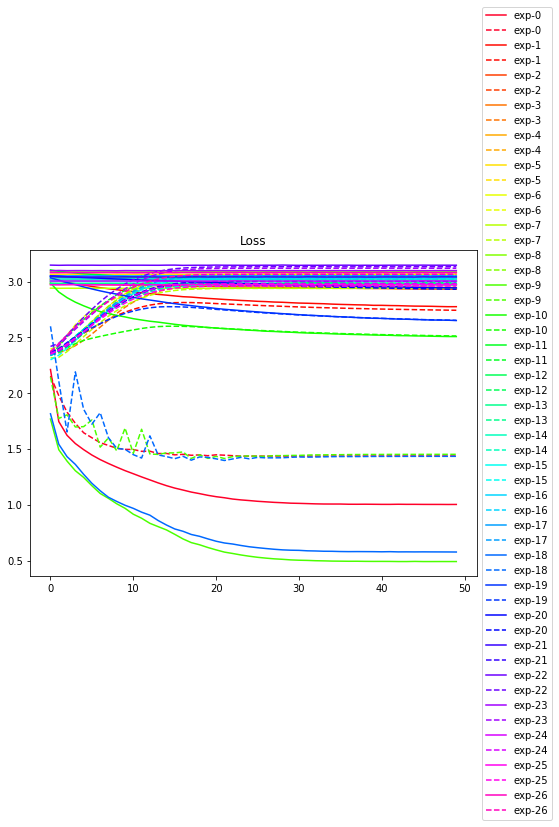

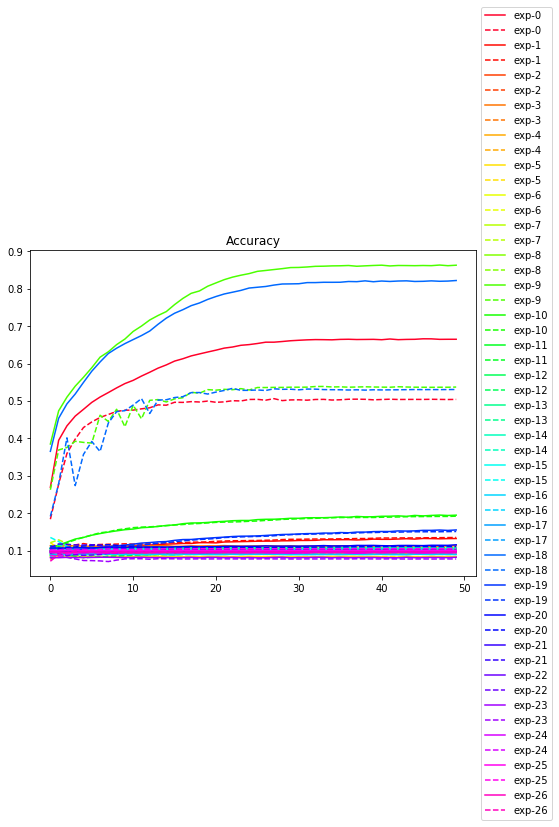

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()